In [1]:
from dataclasses import dataclass
import statistics
from collections import OrderedDict
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sheet_file_name = 'noexcept_keyword_amd_gcc_linux_book1_results.xlsx'
excel_file = load_workbook(sheet_file_name)

# How many rows down does the actual data (we're interested in) start from?
data_start_offset = 7

num_test_cases = excel_file.worksheets[0].max_row - data_start_offset
num_test_cases_per_scene = 50  # TODO would like a "smarter" way of geting this number, not hard coding it...

In [2]:
@dataclass
class TestCase:
    id_num: int
    scene_id: str

    # runtimes, measured in nanoseconds
    baseline_runtime_ns: int
    venture_runtime_ns: int

    def venture_slower_by_ns(self) -> int:
        '''How much slower using the venture was. Could return a negative, meaning the venture was faster'''
        return self.venture_runtime_ns - self.baseline_runtime_ns

    def venture_faster_by_ns(self) -> int:
        '''How much was the venture faster by, may return a negative meaning it was slower'''
        return -self.venture_slower_by_ns()

    def percent_venture_slower_by(self) -> float:
        '''Percent-wise how much slower the venture was'''
        return (self.venture_runtime_ns - self.baseline_runtime_ns) / self.baseline_runtime_ns

    def percent_venture_faster_by(self) -> float:
        '''Percent-wise how much faster the venture was'''
        return (self.baseline_runtime_ns - self.venture_runtime_ns) / self.baseline_runtime_ns

In [3]:
def _ns_to_time_str(nanoseconds: int) -> str:
    total_seconds = nanoseconds // 1000000000
    hours = total_seconds // (60 * 60)
    s = total_seconds % (60 * 60)
    minutes = s // 60
    seconds = s % 60
    
    return f'{hours}h {minutes}m {seconds}s'
    

@dataclass
class TestSuite:
    cpu: str
    os: str
    compiler: str

    # Measured in nanoseconds
    baseline_total_runtime_ns: int
    venture_total_runtime_ns: int

    test_cases: list[TestCase]

    def baseline_total_runtime_str(self) -> str:
        return _ns_to_time_str(self.baseline_total_runtime_ns)
        
    def venture_total_runtime_str(self) -> str:
        return _ns_to_time_str(self.venture_total_runtime_ns)

    def matplotlib_config_name(self) -> str:
        '''For displaying the configuration in matplotlib renderings'''
        return '\n'.join([self.cpu, self.os, self.compiler])

    def pandas_column_header(self) -> str:
        '''For displaying the configuration in a header in a table'''
        return self.matplotlib_config_name().replace('\n', '<br>')

    def overall_was_venture_more_performant(self) -> bool:
        return (self.venture_total_runtime_ns < self.baseline_total_runtime_ns)

    def overall_how_much_faster_was_venture(self) -> float:
        # Assumes that venture was always faster
        diff = self.baseline_total_runtime_ns - self.venture_total_runtime_ns
        return (diff / self.baseline_total_runtime_ns)

    def _find_cases_where(self, comparison_func) -> list[TestCase]:
        '''Internal function to compare the venture vs. non-used-venture test case,
        and collect them into a list.  comparision_func takes one arguement (a test
        case) and should return a bool'''
        return list(filter(lambda x: comparison_func(x), self.test_cases))
        
    def find_cases_where_venture_was_slower(self) -> list[TestCase]:
        '''Retuns a list of test cases where the usage of the venture was slower'''
        def _venture_slower(test_case):
            return (test_case.venture_runtime_ns >= test_case.baseline_runtime_ns)

        return self._find_cases_where(_venture_slower)

    def find_cases_where_venture_was_faster(self) -> list[TestCase]:
        '''Returns a list of test cases where the usage of the venture was faster'''
        def _venture_faster(test_case):
            return (test_case.venture_runtime_ns < test_case.baseline_runtime_ns)

        return self._find_cases_where(_venture_faster)        

    def find_cases_where_venture_was_slower_by_at_least(self, by_percent: float) -> list[TestCase]:
        '''Find where the test case was slower with the venture turned on;  By a certain percentage'''
        all_where_slower = self.find_cases_where_venture_was_slower()
        return list(filter(lambda x: (x.percent_venture_slower_by() >= by_percent), all_where_slower))
        
    def find_cases_where_venture_was_faster_by_at_least(self, by_percent: float) -> list[TestCase]:
        '''Find where the test case was faster with the venture turned on;  By a certain percentage'''
        all_where_faster = self.find_cases_where_venture_was_faster()
        return list(filter(lambda x: (x.percent_venture_faster_by() >= by_percent), all_where_faster))

In [4]:
results = []
num_configurations = 0

def pairwise(iterable):
    a = iter(iterable)
    return zip(a, a)

# Parse the data into something we can use/analyze
for (baseline, venture) in pairwise(excel_file.worksheets):
    num_configurations += 1
    
    # Extract out the summary data
    baseline_summary_data = baseline['A1:B5']
    venture_summary_data = venture['A1:B5']

    # Grab the configuration (and results of each individual test)
    data_start_offset = 8
    range_to_grab = f'A{data_start_offset}:I{data_start_offset + num_test_cases - 1}'
    baseline_test_data = baseline[range_to_grab]
    venture_test_data = venture[range_to_grab]
    
    # Get all the data from each test case
    test_cases = []
    for r in range(0, num_test_cases):
        test_cases.append(TestCase(
            int(baseline_test_data[r][0].value),    # id no.
            baseline_test_data[r][1].value,         # scene name

            # Render time
            int(baseline_test_data[r][8].value),
            int(venture_test_data[r][8].value)
        ))

    # Put them into the suite results
    results.append(TestSuite(
        baseline_summary_data[0][1].value,
        baseline_summary_data[1][1].value,
        baseline_summary_data[2][1].value,
        
        int(baseline_summary_data[4][1].value),
        int(venture_summary_data[4][1].value),
        test_cases
    ))

In [5]:
configs = [x.pandas_column_header() for x in results]
configs[0] += '<br><br><code>HittableList</code>'
configs[1] += '<br><br><code>BVHNode</code>'
configs[2] += '<br><br><code>BVHNode_MorePerformant</code>'

yes_str = '<div style="background-color: #BFFEBC">Yes</div>'
no_str = '<div style="background-color: #FFCFCF">No</div>'

# Make a table showing the overall performance
data = [
    [(yes_str if x.overall_was_venture_more_performant() else no_str) for x in results],
    [('{:.2%}'.format(x.overall_how_much_faster_was_venture())) for x in results],
    [x.baseline_total_runtime_str() for x in results],
    [x.venture_total_runtime_str() for x in results],
]
row_labels = [
    'Was <code>noexcept</code> faster?',
    'By how much',
    'Total run time without <code>noexcept</code>',
    'Total run time with <code>noexcept</code>',
]

overall_table = pd.DataFrame(columns=configs, data=data)
overall_table.style\
  .set_caption(f'<h1>Overall Performance</h1>')\
  .relabel_index(row_labels, axis=0)
#  .set_table_styles([{'selector': 'td', 'props': [('margin', '2em')]}])\

,AMD Ryzen 9 6900HXUbuntu 23.10GCC 13.2.0HittableList,AMD Ryzen 9 6900HXUbuntu 23.10GCC 13.2.0BVHNode,AMD Ryzen 9 6900HXUbuntu 23.10GCC 13.2.0BVHNode_MorePerformant
Was noexcept faster?,Yes,No,Yes
By how much,7.80%,-3.97%,3.50%
Total run time without noexcept,3h 1m 2s,1h 22m 40s,1h 28m 42s
Total run time with noexcept,2h 46m 54s,1h 25m 57s,1h 25m 36s


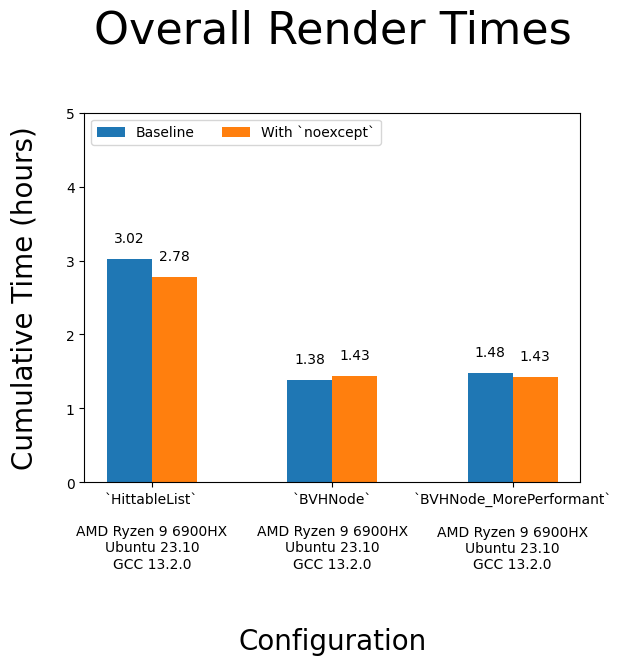

In [6]:
# Bar chart visualization of the above table

def ns_to_s(x: int) -> float:
    return x / 1000000000

def s_to_hr(x: float) -> float:
    return x / 60 / 60

def ns_to_hr(x: int) -> float:
    return s_to_hr(ns_to_s(x))

# Convert the overall suite runtime from nanoseconds to hours
baseline_runtimes = [ns_to_hr(x.baseline_total_runtime_ns) for x in results]
venture_runtimes = [ns_to_hr(x.venture_total_runtime_ns) for x in results]

configs = [x.matplotlib_config_name() for x in results]
configs[0] = '`HittableList`\n\n' + configs[0]
configs[1] = '`BVHNode`\n\n' + configs[1]
configs[2] = '`BVHNode_MorePerformant`\n\n' + configs[2]
runtimes = {
    'Baseline': baseline_runtimes,
    'With `noexcept`': venture_runtimes,
}

# Create the bar chart
x = np.arange(len(configs))
bar_width = 0.25
multiplier = 0.5

#plt.rcParams['figure.figsize'] = [24, 8]
fig, ax = plt.subplots()

for (config_name, runtime_hrs) in runtimes.items():
    offset = bar_width * multiplier
    rects = ax.bar(x + offset, runtime_hrs, bar_width, label=config_name)
    ax.bar_label(rects, padding=10, fmt='%.2f')
    multiplier += 1

ax.set_title('Overall Render Times', fontsize=32, pad=50)
ax.set_ylabel('Cumulative Time (hours)', fontsize=20, labelpad=20)
ax.set_xlabel('Configuration', fontsize=20, labelpad=40)
ax.set_xticks(x + bar_width, configs)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 5)

plt.show()

In [7]:
# Not a fan of doing this, but it extracts the scene Id's for us to display in the table
_scene_ids = []

configs = [x.pandas_column_header() for x in results]
configs[0] += '<br><br><code>HittableList</code>'
configs[1] += '<br><br><code>BVHNode</code>'
configs[2] += '<br><br><code>BVHNode_MorePerformant</code>'

def make_table_for_stat_measurement(function, table_title: str, cmap: str='RdBu', vmin=-0.1, vmax=0.1):
    '''This function will let you make a table that shows the summary for a "satistical measurement" function.

    For example, if you want to see the average performance increase/decrease of "feature-on" vs. "feature off", you would pass in
    `statistics.mean` to `function`.   If you wanted to see the Median, use `statistics.median`.  Note that this
    funtion returns a tuple of the pandas.DataFrame and an styling function to call on the data frame.
    '''
    
    global _scene_ids
    global num_test_cases_per_scene
    global num_test_cases

    data = {}
    for (config_index, config_name) in enumerate(configs):
        all_scenes = OrderedDict()
        suite = results[config_index]

        # Organize each scene to see how much percent faster it is
        for tc in suite.test_cases:
            sid = tc.scene_id
            p_faster = tc.percent_venture_faster_by()
            
            if sid in all_scenes:
                all_scenes[sid].append(p_faster)  # Add value
            else:
                all_scenes[sid] = [p_faster]      # New list

        scene_ids = []
        computed = []
        for (scene_id, measurements) in all_scenes.items():
            scene_ids.append(scene_id)
            computed.append(function(measurements))
            
            
        data[config_name] = computed
    
    def _make_pretty(styler):
        styler.format('{:.1%}')
        styler.set_table_styles([
            {'selector': '.row_heading', 'props': [('text-align', 'left')]}
        ])
        styler.background_gradient(axis=None, cmap=cmap, vmin=vmin, vmax=vmax)
        styler.set_caption(table_title)
        styler.relabel_index(_scene_ids, axis=0)
        return styler

    # Set globals (always will be the same)
    _scene_ids = scene_ids
    num_test_cases_per_scene = num_test_cases / len(_scene_ids)

    # Return data
    table = pd.DataFrame(data=data)
    return (table, _make_pretty)

In [8]:
(table, make_pretty) = make_table_for_stat_measurement(
    statistics.mean,
    f'<h2>Average of how much faster/slower was if <code>noexcept</code> was used</h2><h4>(Each scene being tested at least {int(num_test_cases_per_scene)} times)</h4><br><br>'
)
table.style.pipe(make_pretty)

,AMD Ryzen 9 6900HXUbuntu 23.10GCC 13.2.0HittableList,AMD Ryzen 9 6900HXUbuntu 23.10GCC 13.2.0BVHNode,AMD Ryzen 9 6900HXUbuntu 23.10GCC 13.2.0BVHNode_MorePerformant
book1::surface_normal_sphere,5.7%,-1.9%,-0.4%
book1::grey_sphere,7.0%,-1.2%,0.9%
book1::shiny_metal_sphere,5.5%,-4.7%,5.2%
book1::fuzzy_metal_sphere,5.6%,-6.1%,4.0%
book1::two_glass_one_metal_spheres,6.3%,-4.3%,6.0%
book1::glass_blue_metal_spheres,6.7%,-5.3%,4.7%
book1::red_blue_spheres,5.9%,-3.2%,4.0%
book1::hollow_glass_blue_metal_spheres,6.5%,-4.7%,5.2%
book1::hollow_glass_blue_metal_spheres::far_view,5.8%,-2.5%,5.4%
book1::hollow_glass_blue_metal_spheres::close_view,7.2%,-8.7%,4.1%


In [9]:
(table, make_pretty) = make_table_for_stat_measurement(
    statistics.median,
    f'<h2>Median of how much faster/slower was if <code>noexcept</code> was used</h2><h4>(Each scene being tested at least {int(num_test_cases_per_scene)} times)</h4><br><br>'
)
table.style.pipe(make_pretty)

,AMD Ryzen 9 6900HXUbuntu 23.10GCC 13.2.0HittableList,AMD Ryzen 9 6900HXUbuntu 23.10GCC 13.2.0BVHNode,AMD Ryzen 9 6900HXUbuntu 23.10GCC 13.2.0BVHNode_MorePerformant
book1::surface_normal_sphere,5.9%,-1.7%,0.0%
book1::grey_sphere,7.4%,-1.6%,-0.1%
book1::shiny_metal_sphere,5.0%,-4.5%,5.5%
book1::fuzzy_metal_sphere,6.0%,-5.6%,4.2%
book1::two_glass_one_metal_spheres,6.6%,-4.0%,5.5%
book1::glass_blue_metal_spheres,6.7%,-5.0%,4.5%
book1::red_blue_spheres,5.7%,-2.9%,4.1%
book1::hollow_glass_blue_metal_spheres,6.6%,-4.8%,5.8%
book1::hollow_glass_blue_metal_spheres::far_view,5.8%,-2.2%,4.9%
book1::hollow_glass_blue_metal_spheres::close_view,7.9%,-8.7%,4.3%


In [10]:
(table, make_pretty) = make_table_for_stat_measurement(
    statistics.variance,
    f'<h2>Variance of data measurements for <code>noexcept</code> being on.</h2><h4>(Each scene being tested at least {int(num_test_cases_per_scene)} times), lower is better</h4><br><br>',
    cmap='Reds',
    vmin=0.01,
    vmax=0.1
)
table.style.pipe(make_pretty)

,AMD Ryzen 9 6900HXUbuntu 23.10GCC 13.2.0HittableList,AMD Ryzen 9 6900HXUbuntu 23.10GCC 13.2.0BVHNode,AMD Ryzen 9 6900HXUbuntu 23.10GCC 13.2.0BVHNode_MorePerformant
book1::surface_normal_sphere,0.2%,0.1%,0.2%
book1::grey_sphere,0.2%,0.2%,0.2%
book1::shiny_metal_sphere,0.2%,0.1%,0.3%
book1::fuzzy_metal_sphere,0.2%,0.1%,0.2%
book1::two_glass_one_metal_spheres,0.2%,0.1%,0.2%
book1::glass_blue_metal_spheres,0.1%,0.1%,0.2%
book1::red_blue_spheres,0.2%,0.1%,0.1%
book1::hollow_glass_blue_metal_spheres,0.2%,0.1%,0.2%
book1::hollow_glass_blue_metal_spheres::far_view,0.1%,0.1%,0.2%
book1::hollow_glass_blue_metal_spheres::close_view,0.1%,0.1%,0.1%
